In [1]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import xgboost
from sklearn import preprocessing, linear_model, ensemble, metrics
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from keras import layers, models, optimizers
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


# 准备数据

## abstract

In [4]:
abs_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/TF-IDF/abstract_TF-IDF_300d.xlsx"
abstract = pd.read_excel(abs_filepath, encoding='utf-8')

In [5]:
abstract.shape

(7769, 300)

In [6]:
x_abs = abstract
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_abs, p=None)
c

11.41472916740926

## claims

In [25]:
claim_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/TF-IDF/claims_TF-IDF_300d.xlsx"
claims = pd.read_excel(claim_filepath, encoding='utf-8')

In [26]:
claims.shape

(7769, 300)

In [27]:
x_claims = claims
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_claims, p=None)
c

22.807625056281406

## text_sum

In [28]:
sum_feature = pd.concat([abstract,claims],  axis=1, ignore_index=True)
sum_feature.shape

(7769, 600)

In [29]:
x_text = sum_feature
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_text, p=None)
c

32.9052881199286

## result

In [7]:
data = pd.read_excel("/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result_2010.xlsx", encoding='utf-8')

In [8]:
result = data['result']

In [9]:
train_target = np_utils.to_categorical(data[['result']], 2)
y_ints = [y.argmax() for y in train_target]
cw = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)
cw

array([1.49346405, 0.75164474])

In [10]:
train_target.shape

(7769, 2)

# PCA降维

In [74]:
pca = PCA(0.95)
x = pca.fit_transform(x)
x.shape

In [77]:
pca.explained_variance_ratio_

array([0.23741834, 0.16370374, 0.11579571, 0.06891193, 0.05665438,
       0.03903511, 0.03543255, 0.03433684, 0.02892042, 0.02292958,
       0.01830412, 0.01523005, 0.01480394, 0.01303235, 0.01152857,
       0.01149545, 0.0093153 , 0.00872506, 0.00738233, 0.00675595,
       0.00570286, 0.0055471 , 0.00527014, 0.00510093, 0.00456021,
       0.00394785, 0.00379775])

# 划分训练集

In [30]:
x_abs_train = x_abs[:6215]
x_abs_valid = x_abs[6215:6992]
x_abs_test = x_abs[6992:]

x_claims_train = x_claims[:6215]
x_claims_valid = x_claims[6215:6992]
x_claims_test = x_claims[6992:]

x_text_train = x_text[:6215]
x_text_valid = x_text[6215:6992]
x_text_test = x_text[6992:]

In [12]:
y_binary_train = result[:6215]
y_binary_valid = result[6215:6992]
y_binary_test = result[6992:]

y_category_train = train_target[:6215]
y_category_valid = train_target[6215:6992]
y_category_test = train_target[6992:]

In [13]:
sum(y_category_train[:,1])/sum(y_category_train[:,0])

1.9765325670498084

# 机器学习分类

In [31]:
def train_model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    
    y_predict = classifier.predict(x_test)# 每一个x的预测值
    y_predict_proba = classifier.predict_proba(x_test) # 预测分类的概率
    
    precision = metrics.precision_score(y_test, y_predict) # 精确率
    recall = metrics.recall_score(y_test, y_predict) # 召回率
    f1 = metrics.f1_score(y_test, y_predict) # f1
    accuracy = metrics.accuracy_score(y_test, y_predict, normalize = True) # 准确率
    
    # print("accuracy: {:.4f} precision: {:.4f} recall: {:.4f} f1: {:.4f}".format(accuracy,precision,recall,f1))
    
    return y_predict,y_predict_proba

## abstract

In [458]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, class_weight="balanced", penalty='l2', C=0.005, fit_intercept=True), 
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=400)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [481]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_abs_train, y_binary_train, x_abs_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:15<00:00,  5.11s/it]


In [482]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [415]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.5946
LR macro:  0.5766
LR weighted:  0.6046
[0.5946]
[0.5766]
[0.6046]


In [416]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4278    0.5720    0.4895       264
           1     0.7335    0.6062    0.6638       513

    accuracy                         0.5946       777
   macro avg     0.5806    0.5891    0.5766       777
weighted avg     0.6296    0.5946    0.6046       777



In [417]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.5946
RF macro:  0.5213
RF weighted:  0.5813
[0.5946]
[0.5213]
[0.5813]


In [418]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.3780    0.2992    0.3340       264
           1     0.6743    0.7466    0.7086       513

    accuracy                         0.5946       777
   macro avg     0.5261    0.5229    0.5213       777
weighted avg     0.5736    0.5946    0.5813       777



In [461]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.5933
XGB macro:  0.5341
XGB weighted:  0.5873
[0.5946]
[0.5213]
[0.5813]


In [462]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.3898    0.3485    0.3680       264
           1     0.6821    0.7193    0.7002       513

    accuracy                         0.5933       777
   macro avg     0.5360    0.5339    0.5341       777
weighted avg     0.5828    0.5933    0.5873       777



## claims

In [533]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, class_weight="balanced", penalty='l2', C=0.01, fit_intercept=True), 
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=400)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [534]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_claims_train, y_binary_train, x_claims_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:23<00:00,  7.85s/it]


In [535]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [536]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6088
LR macro:  0.5912
LR weighted:  0.6183
[0.6088]
[0.5912]
[0.6183]


In [537]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4432    0.5909    0.5065       264
           1     0.7459    0.6179    0.6759       513

    accuracy                         0.6088       777
   macro avg     0.5945    0.6044    0.5912       777
weighted avg     0.6430    0.6088    0.6183       777



In [468]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6332
RF macro:  0.5560
RF weighted:  0.6153
[0.6332]
[0.556]
[0.6153]


In [469]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.4444    0.3182    0.3709       264
           1     0.6939    0.7953    0.7411       513

    accuracy                         0.6332       777
   macro avg     0.5692    0.5568    0.5560       777
weighted avg     0.6091    0.6332    0.6153       777



In [470]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.6332
XGB macro:  0.5594
XGB weighted:  0.6172
[0.6332]
[0.556]
[0.6153]


In [471]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4462    0.3295    0.3791       264
           1     0.6959    0.7895    0.7397       513

    accuracy                         0.6332       777
   macro avg     0.5710    0.5595    0.5594       777
weighted avg     0.6110    0.6332    0.6172       777



## text_sum

In [549]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, class_weight="balanced", penalty='l2', C=0.03, fit_intercept=True), 
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=200), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=400)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [550]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_text_train, y_binary_train, x_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [02:07<00:00, 42.51s/it]


In [551]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [546]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6139
LR macro:  0.5966
LR weighted:  0.6234
[0.6139]
[0.5966]
[0.6234]


In [547]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4489    0.5985    0.5130       264
           1     0.7506    0.6218    0.6802       513

    accuracy                         0.6139       777
   macro avg     0.5997    0.6102    0.5966       777
weighted avg     0.6481    0.6139    0.6234       777



In [552]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6705
RF macro:  0.4658
RF weighted:  0.5718
[0.6705]
[0.4658]
[0.5718]


In [553]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.6250    0.0758    0.1351       264
           1     0.6725    0.9766    0.7965       513

    accuracy                         0.6705       777
   macro avg     0.6487    0.5262    0.4658       777
weighted avg     0.6563    0.6705    0.5718       777



In [478]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.6551
XGB macro:  0.5775
XGB weighted:  0.6355
[0.6242]
[0.5409]
[0.6036]


In [479]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4889    0.3333    0.3964       264
           1     0.7052    0.8207    0.7586       513

    accuracy                         0.6551       777
   macro avg     0.5970    0.5770    0.5775       777
weighted avg     0.6317    0.6551    0.6355       777



## 绘图

100%|█| 3/3 [00:00<0


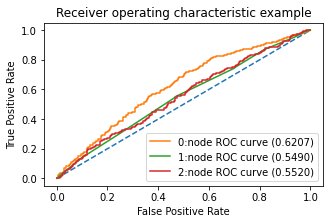

In [463]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


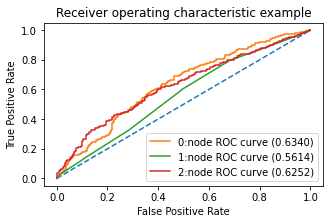

In [538]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


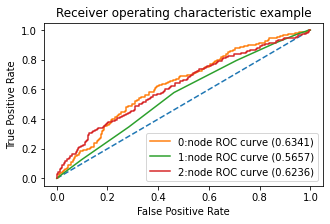

In [548]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 神经网络分类

In [29]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [83]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    Dense_layer_1 = layers.Dense(360, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(480, activation="relu")(Dense_layer_1)
    Dense_layer_2 = layers.Dropout(0.3)(Dense_layer_2)
    Dense_layer_3 = layers.Dense(128, activation="relu")(Dense_layer_2)
    Dense_layer_3 = layers.Dropout(0.5)(Dense_layer_3)
    Dense_layer_4 = layers.Dense(2, activation='softmax')(Dense_layer_3)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_4)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [31]:
# 提前停止监视器设置为3，这意味着在连续3次运行后，模型的性能没有改进的话，训练将会被停止
my_callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=5)
]

In [134]:
history_list = []
model_list = []

for i in tqdm(range(10), ncols=70):
    model = full_connect_network(x_abs_train.shape[1])
    history = model.fit(x_abs_train, y_category_train, 
                        validation_data=(x_abs_valid, y_category_valid), 
                        verbose=0, epochs=100, batch_size=128, shuffle=False,
                        callbacks=my_callbacks,
                        class_weight=cw)
    history_list.append(history)
    model_list.append(model)

100%|█████████████████████████████████| 10/10 [01:37<00:00,  9.77s/it]


In [136]:
# loss, acc = model.evaluate(x_valid, y_valid, batch_size=64, verbose=1)
# print("accuracy: {:.4f} loss: {:.4f}".format(acc,loss))

metrics_list = []
for model in tqdm(model_list, ncols=70):
    y_pred = model.predict(x_abs_test, batch_size=64, verbose=0)
    # y_pred_1 = np.rint(y_pred) #四舍五入取整
    for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
    report = classification_report(y_category_test, y_pred, digits=4)
    p = re.compile('  |\n', re.S)
    report = p.sub(' ', report)
    metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
    metrics_list.append(metrics_content)

100%|█████████████████████████████████| 10/10 [00:33<00:00,  3.38s/it]


In [137]:
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

NN acc:  0.6544
NN macro:  0.4678
NN weighted:  0.5688
[0.6615, 0.6525, 0.6525, 0.6486, 0.6525, 0.6564, 0.6564, 0.6486, 0.6615, 0.6538]
[0.4837, 0.4662, 0.4637, 0.4539, 0.4637, 0.4709, 0.4709, 0.4539, 0.4813, 0.4695]
[0.5808, 0.5673, 0.5657, 0.5584, 0.5657, 0.5713, 0.5713, 0.5584, 0.5793, 0.5697]


In [126]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4000    0.0682    0.1165       264
           1     0.6639    0.9474    0.7807       513

   micro avg     0.6486    0.6486    0.6486       777
   macro avg     0.5320    0.5078    0.4486       777
weighted avg     0.5743    0.6486    0.5550       777
 samples avg     0.6486    0.6486    0.6486       777



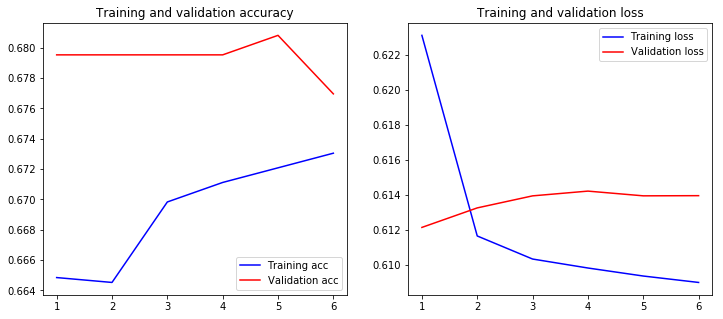

In [95]:
plot_history(history_list[0])